In [ ]:
# default_exp sine_model

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2

In [ ]:
#export
from rtma.imports import *
from rtma.core import *
from rtma.signal import *
from rtma.fft import *
from rtma.stft import *

# Sine Model

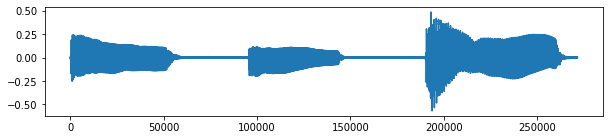

In [ ]:
fn = "data/E_octaves_both.wav"
x, sr = load_audio(fn)
plot(x)

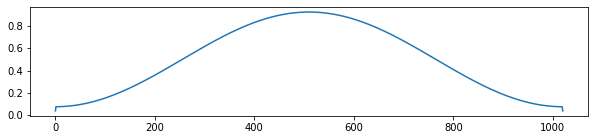

In [ ]:
n_fft = 1024
h = 510
m = h*2 + 1
wn = 'hamming'
w = get_cola_window('hamming', m, h)
plot(w)

In [ ]:
spectrum = list(stft(x, n_fft, h, w))
mx, px = (np.stack(s) for s in zip(*spectrum))
mx = 20*np.log10(mx)
print(f'n_fft: {n_fft}, m: {m}, h: {h}, w: {wn}')
mx.shape, px.shape

n_fft: 1024, m: 1021, h: 510, w: hamming


((534, 513), (534, 513))

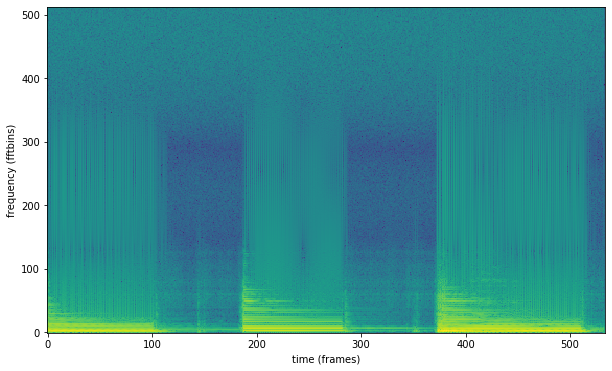

In [ ]:
plot_mags(mx)

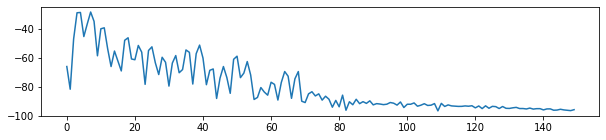

In [ ]:
frame_i = 200
mags = mx[frame_i]
plot(mags[:150])

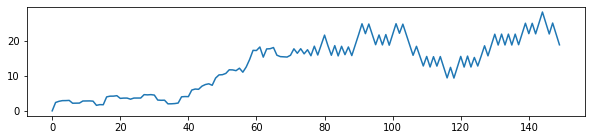

In [ ]:
phases = px[frame_i]
plot(phases[:150])

## Peak Detection

In [ ]:
#export
def detect_peaks(x, thresh):
    # first and last cannot be peaks
    above_thresh = np.greater(x[1:-1], thresh)
    gt_before = np.greater(x[1:-1], x[:-2])
    gt_after =  np.greater(x[1:-1], x[2:])
    is_peak = above_thresh & gt_before & gt_after
    peaks_i = is_peak.nonzero()[0] + 1
    return peaks_i 

In [ ]:
arr = np.array([2, 10, 3, 8, -2, 3, 1, 9, 0, 2, 1])
assert np.array_equal(detect_peaks(arr, 1), [1,3,5,7,9])
assert np.array_equal(detect_peaks(arr, 2), [1,3,5,7])
assert np.array_equal(detect_peaks(arr, 3), [1,3,7])

In [ ]:
#export
def plot_peaks(x, peak_i, t=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x)
    plt.plot(peak_i, x[peak_i], marker='x', color='r', linestyle='', markeredgewidth=1.5)
    if t is not None:
        plt.axhline(t, c='g')

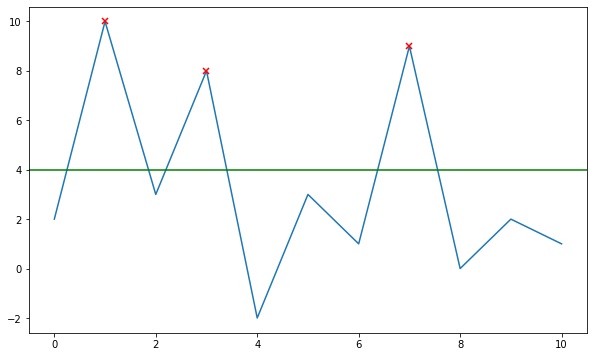

In [ ]:
t = 4
plot_peaks(arr, detect_peaks(arr, t), t)

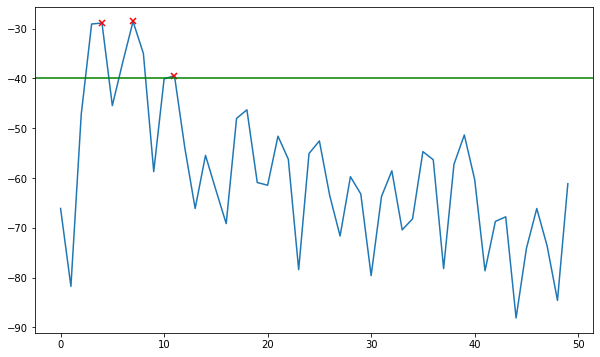

In [ ]:
t = -40
peak_i = detect_peaks(mags, t)[:10]
plot_peaks(mags[:50], peak_i, t)

## Peak Interpolation

In [ ]:
#export
def interpolate_peaks(mags, peak_i):
    a, b, c = mags[peak_i-1], mags[peak_i], mags[peak_i+1]
    ipeak_i = peak_i + 0.5 * (a - c) / (a - 2*b + c)
    ipeak_mags = b - 0.25 * (a - c) * (ipeak_i - peak_i)
    return ipeak_i, ipeak_mags

In [ ]:
#export
def plot_ipeaks(mags, ipeak_i, ipeak_mag, peak_i=None, t=None):
    plt.figure(figsize=(10, 6))
    plt.plot(mags)
    plt.plot(ipeak_i, ipeak_mag, marker='x', color='g', linestyle='', markeredgewidth=1.5)
    if peak_i is not None:
        plt.plot(peak_i, mags[peak_i], marker='x', color='r', linestyle='', markeredgewidth=1.5)
    if t is not None:
        plt.axhline(t, c='g')

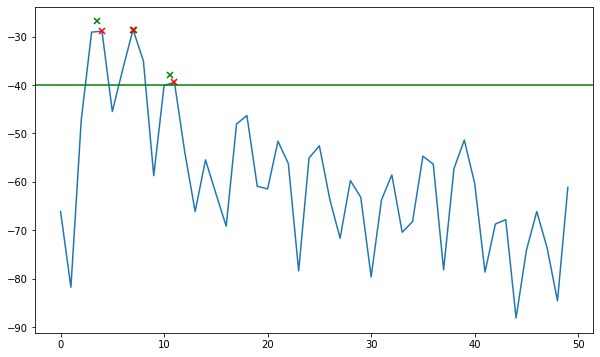

In [ ]:
ipeak_i, ipeak_mag = interpolate_peaks(mags, peak_i)
plot_ipeaks(mags[:50], ipeak_i, ipeak_mag, peak_i=peak_i, t=t)

In [ ]:
ipeak_freq = sr * ipeak_i / n_fft
ipeak_freq

array([164.61361836, 331.0181719 , 494.25827267])

In [ ]:
idx = np.arange(phases.size)
ipeak_phase = np.interp(ipeak_i, idx, phases)
ipeak_phase

array([2.928796  , 2.19993749, 2.83588188])

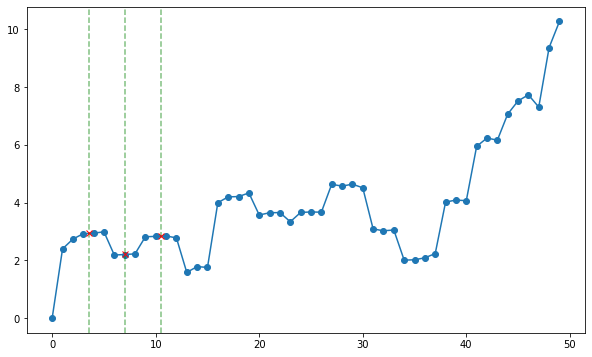

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(idx[:50], phases[:50], marker='o')
for i in ipeak_i:
    plt.axvline(i, c='g', linestyle='--', alpha=0.5)
plt.plot(ipeak_i, ipeak_phase, c='r', linestyle='', marker='x')

## Synthesis

In [ ]:
def sinc(x, N):
    y = np.sin(N * x/2) / np.sin(x/2)                  # compute the sinc function
    y[np.isnan(y)] = N                                 # avoid NaN if x == 0
    return y

def genBhLobe(x, N=512):
    f = x*np.pi*2/N                                         # frequency sampling
    df = 2*np.pi/N
    y = np.zeros(x.size)                                    # initialize window
    consts = [0.35875, 0.48829, 0.14128, 0.01168]           # window constants
    for m in range(0,4):                                    # iterate over the four sincs to sum
        y += consts[m]/2 * (sinc(f-df*m, N) + sinc(f+df*m, N))  # sum of scaled sinc functions
    y = y/N/consts[0]                                       # normalize
    return y

/home/john/miniconda3/envs/rtma/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


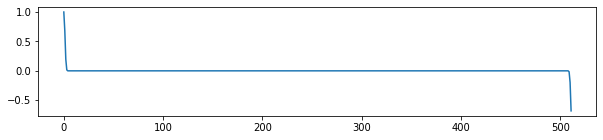

In [ ]:
a = np.arange(512)
plot(genBhLobe(a))

In [ ]:
def generate_sine_spectrum(ipeak_f, ipeak_m, ipeak_p, N, fs):
    Y = np.zeros(N, dtype=np.complex64)
    hN = N//2
    
    ipeak_i = ipeak_f * N / fs
    assert (ipeak_i > 0).all()  # not sure 
    assert (ipeak_i <= hN).all(), f'{ipeak_i.max(), hN}'
    
    for i, mag, phase in zip(ipeak_i, ipeak_m, ipeak_p):
        bin_remainder = round(i) - i
        lb = np.arange(bin_remainder-4, bin_remainder+5)
        lmag = genBhLobe(lb) * 10**(mag/20)
        bs = np.arange(round(i) - 4, round(i) + 5, dtype=int)        
        for m, b in enumerate(bs):
            if b < 0:      # lobe crosses DC
                Y[-b] += lmag[m]*np.exp(-1j*phase)
            
            elif b > hN:   # lobe crosses nyquist
                Y[b] += lmag[m] * np.exp(-1j*phase)
            
            elif b == 0 or b == hN:   #limits of spectrum
                Y[b] += lmag[m]*np.exp(1j*phase) + lmag[m]*np.exp(-1j*phase)
            
            else:  # pos freq range
                Y[b] += lmag[m]*np.exp(1j*phase)
            
        Y[hN+1:] = Y[hN-1:0:-1].conjugate()
    return Y
            

Y = generate_sine_spectrum(ipeak_freq, ipeak_mag, ipeak_phase, n_fft, sr)

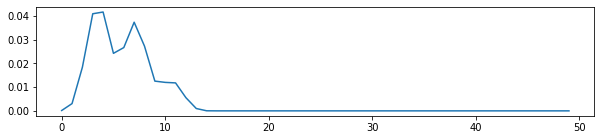

In [ ]:
plot(abs(Y)[:50])

### blackman window..

In [ ]:
bh = genBhLobe(np.arange(6))
bh[:6]

/home/john/miniconda3/envs/rtma/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([ 1.00000000e+00,  6.80543554e-01,  1.96905923e-01,  1.62787456e-02,
       -6.50095043e-21,  6.50131411e-21])

In [ ]:
m = 512
bh = get_window('blackmanharris', m)
bh /= bh.sum()
bhm, bhp = fft_analysis(bh, m)
bhm[:6]

array([1.00000000e+00, 6.80543554e-01, 1.96905923e-01, 1.62787456e-02,
       4.52955313e-18, 1.92231474e-17])

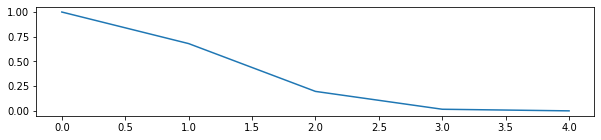

In [ ]:
plot(bhm[:5])

## sineModel

In [ ]:
x, sr = load_audio(fn)
n_fft = 2048
m = 1001
h = 512
t = -80
w = get_cola_window('hamming', n_fft, h)

In [ ]:
w.sum()

512.0

In [ ]:
from scipy.signal import blackmanharris, triang

In [ ]:
#export
def synth_window(n_fft: int) -> np.ndarray:
    h = n_fft // 4
    t_win = triang(2 * h)
    t_win = np.pad(t_win, (h, h), mode='constant')
    bh_win = blackmanharris(n_fft)
    bh_win /= bh_win.sum()
    win = t_win / bh_win
    return win

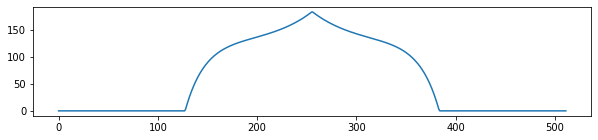

In [ ]:
sw = synth_window(512)
plot(sw)

In [ ]:
sw.sum()

31544.949755809088

In [ ]:
def sine_model(x, fs, w, n_fft, t):
    n_fft_synth = 512
    h = n_fft_synth // 4
    
    sw = synth_window(n_fft_synth)

    frames = []
    for mx, px in stft(x, n_fft, h, w):
        mx_db = 20 * np.log10(mx)
        
        peak_i = detect_peaks(mx_db, t)
        ipeak_i, ipeak_m = interpolate_peaks(mx_db, peak_i)
        ipeak_p = np.interp(ipeak_i, np.arange(px.size), px)
        ipeak_f = fs * ipeak_i / n_fft
        
        Y = generate_sine_spectrum(ipeak_f, ipeak_m, ipeak_p, n_fft_synth, fs)
        fft_buffer = np.real(np.fft.ifft(Y))
        yw = zero_phase_buffer(fft_buffer, n_window=n_fft_synth, reverse=True)        
        frames.append(sw*yw)
        
    return synth_frames(frames, h, x.size)

In [ ]:
x.shape, w.shape, n_fft, t, sr

((271522,), (2048,), 2048, -80, 48000)

In [ ]:
w.sum()

512.0

In [ ]:
%%time

y = sine_model(x, sr, w, n_fft, t)

CPU times: user 5.12 s, sys: 0 ns, total: 5.12 s
Wall time: 5.12 s


In [ ]:
# 4.35s to generate a 5.66s sound

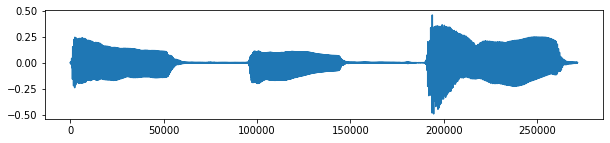

In [ ]:
plot(y)

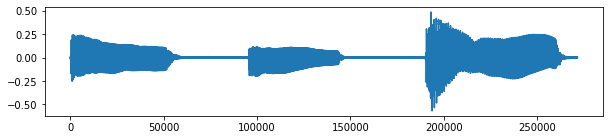

In [ ]:
plot(x)

In [ ]:
import IPython.display as ipd

In [ ]:
ipd.display(ipd.Audio(x, rate=sr))

In [ ]:
ipd.display(ipd.Audio(y, rate=sr))

## Sine Model Analysis

In [ ]:
class Frame:
    def __init__(self, freqs=None, mags=None, phases=None):
        self.freqs = freqs
        self.mags = mags
        self.phases = phases
    
    def __len__(self):
        return len(self.freqs) if self.freqs else 0

In [ ]:
def sine_model_analysis(x, fs, w, n_fft, h, t):
    frames = []
    for frame_i, (mx, px) in enumerate(stft(x, n_fft, h, w)):
        mx_db = 20.0 * np.log10(mx)        
        peak_i = detect_peaks(mx_db, t)
        ipeak_i, ipeak_m = interpolate_peaks(mx_db, peak_i)
        ipeak_p = np.interp(ipeak_i, np.arange(px.size), px)
        ipeak_f = fs * ipeak_i / n_fft

        frame = Frame(ipeak_f, ipeak_m, ipeak_p)
        frames.append(frame)
        
    return frames

In [ ]:
%%time

frames = sine_model_analysis(x, sr, w, n_fft, h, t)
len(frames)

CPU times: user 88.5 ms, sys: 0 ns, total: 88.5 ms
Wall time: 88.2 ms


534

In [ ]:
#export
def synth_window(n_fft: int, h: int) -> np.ndarray:
    t_win = triang(2 * h)
    padding = (n_fft - 2*h) // 2
    t_win = np.pad(t_win, (padding, padding), mode='constant')
    bh_win = blackmanharris(n_fft)
    bh_win /= bh_win.sum()
    win = t_win / bh_win
    return win

In [ ]:
def sine_model_synthesis(frames, n_fft, h, fs):
    n_frames = len(frames)
    y_length = h*(n_frames - 1) + n_fft
    y = np.zeros(y_length)
    
    synth_win = synth_window(n_fft, h)    

    for i, f in enumerate(frames):        
        Y = generate_sine_spectrum(f.freqs, f.mags, f.phases, n_fft, fs)        
        fft_buffer = np.real(np.fft.ifft(Y))
        yw = zero_phase_buffer(fft_buffer, n_window=n_fft, reverse=True)   
        offset = i*h
        y[offset:offset+n_fft] += synth_win * yw
        
    return y
        

In [ ]:
%%time

sr1 = sr
y = sine_model_synthesis(frames, 4096, 512, sr1)

y = y[2048-512:]
y = y[:x.size]

CPU times: user 31.9 ms, sys: 3.67 ms, total: 35.6 ms
Wall time: 35 ms


In [ ]:
ipd.display(ipd.Audio(y, rate=sr1))
y.shape

(271522,)

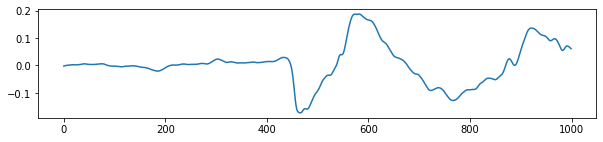

In [ ]:
plot(x[:1000])

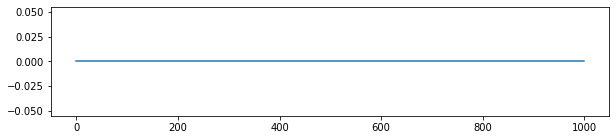

In [ ]:
plot(y[:1000])